In [ ]:
pwd

'/content'

In [ ]:
cd ..

/


In [ ]:
ls

bin/      dev/   lib32/  NGC-DL-CONTAINER-LICENSE  root/  sys/    var/
boot/     etc/   lib64/  opt/                      run/   tmp/
content/  home/  media/  proc/                     sbin/  tools/
datalab/  lib/   mnt/    python-apt/               srv/   usr/


In [ ]:
mkdir input

In [ ]:
ls

bin/      dev/    lib/    mnt/                      python-apt/  srv/    usr/
boot/     etc/    lib32/  NGC-DL-CONTAINER-LICENSE  root/        sys/    var/
content/  home/   lib64/  opt/                      run/         tmp/
datalab/  input/  media/  proc/                     sbin/        tools/


In [ ]:
cd input/

/input


In [ ]:
mkdir spaceship-titanic

In [ ]:
ls

spaceship-titanic/


In [ ]:
cd spaceship-titanic/

/input/spaceship-titanic


In [ ]:
pwd

'/input/spaceship-titanic'

In [ ]:
cd ../../

/


In [ ]:
cd content/

/content


In [ ]:
ls

sample_data/  sample_submission.csv  test.csv  train.csv


In [ ]:
cp train.csv ../input/spaceship-titanic/

In [ ]:
cp test.csv ../input/spaceship-titanic/

In [ ]:
cp sample_submission.csv ../input/spaceship-titanic/

In [ ]:
## Parameters
data_config = {
    'train_csv_path': '../input/spaceship-titanic/train.csv',
    'test_csv_path': '../input/spaceship-titanic/test.csv',
    'sample_submission_path': '../input/spaceship-titanic/sample_submission.csv',
}

exp_config = {
    'n_bins': 10,
    'n_splits': 5,
    'batch_size': 512,
    'learning_rate': 5e-4,
    'weight_decay': 0.0001,
    'train_epochs': 30,
    'checkpoint_filepath': './tmp/model/checkpoint.cpt',
    'finalize': True,
    'finalize_epochs': None,
    'finalized_filepath': './tmp/model/finalized.cpt',
}

model_config = {
    'model': 'gmlp',  ##  'tabtransformer' or 'gmlp'
    'cat_embedding_dim': 12,  ## parameter for both TabTransformer and gMLP
    'num_transformer_blocks': 4,  ## TabTransformer's parameter
    'num_heads': 3,  ## TabTransformer's parameter
    'tf_dropout_rates': [0., 0., 0., 0.,],  ## TabTransformer's parameter
    'ff_dropout_rates': [0., 0., 0., 0.,],  ## TabTransformer's parameter
    'mlp_dropout_rates': [0.2,],  ## TabTransformer's parameter
    'mlp_hidden_units_factors': [1],  ## TabTransformer's parameter
    'num_proj_factor': 4,  ## TabTransformer's parameter
    'gmlp_num_blocks': 30,  ## gMLP's parameter
    'gmlp_split': True,  ## gMLP's parameter
    'gmlp_proj_factor': 3,  ## gMLP's parameter
    'gmlp_dropout': [0.,],  ## gMLP's parameter
    'mlp_factors': [],  ## gMLP's parameter
    'gmlp_init_eps': 1e-3,  ## gMLP's parameter
    'feature_pooling': False,  ## gMLP's parameter
}

print('Parameters setted!')

Parameters setted!


In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow_addons

In [ ]:
## Import dependencies 
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os, sys, pathlib, gc
import re, math, random, time
import datetime as dt
from tqdm import tqdm
from typing import Optional, Union, Tuple
from collections import OrderedDict

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

print('import done!')

import done!


In [ ]:
## For reproducible results    
def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed(s)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(s) 
    print('Seeds setted!')
global_seed = 42
seed_all(global_seed)

## Limit GPU Memory in TensorFlow
## Because TensorFlow, by default, allocates the full amount of available GPU memory when it is launched. 
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")
    
## For Seaborn Setting
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha': 0.3,
    'figure.figsize': (16, 6),
    'axes.titlesize': 'Large',
    'axes.labelsize': 'Large',
    'figure.facecolor': '#fdfcf6',
    'axes.facecolor': '#fdfcf6',
}
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
sns.set_theme(
    style='whitegrid',
    #palette=sns.color_palette(cluster_colors),
    rc=custom_params,)

Seeds setted!
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True


In [ ]:
## Data Loading
train_df = pd.read_csv(data_config['train_csv_path'])
test_df = pd.read_csv(data_config['test_csv_path'])
submission_df = pd.read_csv(data_config['sample_submission_path'])

print(f'train_length: {len(train_df)}')
print(f'test_lenght: {len(test_df)}')
print(f'submission_length: {len(submission_df)}')

train_length: 8693
test_lenght: 4277
submission_length: 4277


In [ ]:
## Null Value Check
print('train_df.info()'); print(train_df.info(), '\n')
print('test_df.info()'); print(test_df.info(), '\n')

## train_df Check
train_df.head()

train_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None 

test_df.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
## Feature Selection
numerical_columns = ['Age', 'RoomService', 'FoodCourt',
                     'ShoppingMall', 'Spa', 'VRDeck']
categorical_columns = ['PassengerId', 'HomePlanet', 'CryoSleep',
                       'Cabin', 'Destination', 'VIP', 'Name']
target = 'Transported'

## Number of unique values in each categorical features.
categorical_n_unique = {cc: train_df[cc].nunique() \
                        for cc in categorical_columns}
categorical_n_unique

{'PassengerId': 8693,
 'HomePlanet': 3,
 'CryoSleep': 2,
 'Cabin': 6560,
 'Destination': 3,
 'VIP': 2,
 'Name': 8473}

In [ ]:
## Function for Data Preprocessing
def preprocess_df(dataframe):
    df = dataframe.copy()
    
    ## Drop 'Name'
    df = df.drop(['Name'], axis=1)
    
    ## Transform 'Transported' column to 0 or 1.
    if 'Transported' in df.columns:
        df.loc[df['Transported']==True, 'Transported'] = 1.
        df.loc[df['Transported']==False, 'Transported'] = 0.
        df['Transported'] = df['Transported'].astype('int64')
    
    ## Transform True-False features (CryoSleep and VIP) to 'Yes' or 'No'.
    df.loc[df['CryoSleep']==True, 'CryoSleep'] = 'Yes'
    df.loc[df['CryoSleep']==False, 'CryoSleep'] = 'No'
    df['CryoSleep'] = df['CryoSleep'].astype(str)
    
    df.loc[df['VIP']==True, 'VIP'] = 'Yes'
    df.loc[df['VIP']==False, 'VIP'] = 'No'
    df['VIP'] = df['VIP'].astype(str)
    
    ## Transform the dtypes of HomePlanet and Destination to str
    df['HomePlanet'] = df['HomePlanet'].astype(str)
    df['Destination'] = df['Destination'].astype(str)
    
    return df

train = preprocess_df(train_df)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,No,B/0/P,TRAPPIST-1e,39.0,No,0.0,0.0,0.0,0.0,0.0,0
1,0002_01,Earth,No,F/0/S,TRAPPIST-1e,24.0,No,109.0,9.0,25.0,549.0,44.0,1
2,0003_01,Europa,No,A/0/S,TRAPPIST-1e,58.0,Yes,43.0,3576.0,0.0,6715.0,49.0,0
3,0003_02,Europa,No,A/0/S,TRAPPIST-1e,33.0,No,0.0,1283.0,371.0,3329.0,193.0,0
4,0004_01,Earth,No,F/1/S,TRAPPIST-1e,16.0,No,303.0,70.0,151.0,565.0,2.0,1


In [ ]:
## Handle 'Cabin' feature
def cabin_split(dataframe):
    df = dataframe.copy()
    
    df['Cabin'] = df['Cabin'].astype(str)
    cabins = df['Cabin'].str.split('/', expand=True)
    cabins.columns = ['Cabin_0', 'Cabin_1', 'Cabin_2']
    
    df = pd.concat([df, cabins], axis=1)
    df = df.drop(['Cabin'], axis=1)
    df['Cabin_0'].astype(str)
    df['Cabin_1'] = pd.to_numeric(df['Cabin_1'], errors='coerce')
    df['Cabin_2'].astype(str)
    df['Cabin_2'] = df['Cabin_2'].map(lambda x: 'nan' if x is None else x)
    
    return df

train = cabin_split(train)
train.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_0,Cabin_1,Cabin_2
0,0001_01,Europa,No,TRAPPIST-1e,39.0,No,0.0,0.0,0.0,0.0,0.0,0,B,0.0,P
1,0002_01,Earth,No,TRAPPIST-1e,24.0,No,109.0,9.0,25.0,549.0,44.0,1,F,0.0,S
2,0003_01,Europa,No,TRAPPIST-1e,58.0,Yes,43.0,3576.0,0.0,6715.0,49.0,0,A,0.0,S
3,0003_02,Europa,No,TRAPPIST-1e,33.0,No,0.0,1283.0,371.0,3329.0,193.0,0,A,0.0,S
4,0004_01,Earth,No,TRAPPIST-1e,16.0,No,303.0,70.0,151.0,565.0,2.0,1,F,1.0,S


In [ ]:
## Count positive and negative 'Transported'
train_pos = train.query('Transported==1').reset_index(drop=True)
train_neg = train.query('Transported==0').reset_index(drop=True)
print(f'positive samples: {len(train_pos)}, negative samples: {len(train_neg)}')

positive samples: 4378, negative samples: 4315


In [ ]:
## Target Distribution
target_count = train.groupby(['Transported'])['PassengerId'].count()
target_percent = target_count / target_count.sum()

fig = go.Figure()
data = go.Bar(x=target_count.index.astype(str).values, 
              y=target_count.values)
fig.add_trace(data)
fig.update_layout(title = dict(text="Target distribution"),
                  xaxis = dict(title="'Transported' values"),
                  yaxis = dict(title='counts'))
fig.show()

In [ ]:
## Statistics of Numerical Features
train.describe().T.style.bar(subset=['mean'],)\
                        .background_gradient(subset=['std'], cmap='coolwarm')\
                        .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000
Transported,8693.000000,0.503624,0.500016,0.000000,0.000000,1.000000,1.000000,1.000000
Cabin_1,8494.000000,600.367671,511.867226,0.000000,167.250000,427.000000,999.000000,1894.000000


In [ ]:
## Statistics based on 'Transported' (pos or neg)
train.groupby('Transported').describe().T

Transported                    0             1
Age          count   4226.000000   4288.000000
             mean      29.922858     27.748834
             std       13.699262     15.151705
             min        0.000000      0.000000
             25%       21.000000     18.000000
             50%       27.000000     26.000000
             75%       38.000000     37.000000
             max       79.000000     78.000000
RoomService  count   4217.000000   4295.000000
             mean     389.266066     63.098021
             std      875.638123    274.812497
             min        0.000000      0.000000
             25%        0.000000      0.000000
             50%        1.000000      0.000000
             75%      473.000000      0.000000
             max    14327.000000   3992.000000
FoodCourt    count   4231.000000   4279.000000
             mean     382.615930    532.691984
             std     1200.115601   1931.306995
             min        0.000000      0.000000
             25%        0.000000      0.000000
             50%        0.000000      0.000000
             75%      179.000000      0.000000
             max    16856.000000  29813.000000
ShoppingMall count   4221.000000   4264.000000
             mean     167.566217    179.829972
             std      456.528126    722.026714
             min        0.000000      0.000000
             25%        0.000000      0.000000
             50%        0.000000      0.000000
             75%       95.000000      0.000000
             max    10705.000000  23492.000000
Spa          count   4223.000000   4287.000000
             mean     564.382666     61.675531
             std     1551.356047    262.682871
             min        0.000000      0.000000
             25%        0.000000      0.000000
             50%        4.000000      0.000000
             75%      453.500000      0.000000
             max    22408.000000   4103.000000
VRDeck       count   4225.000000   4280.000000
             mean     543.629822     69.148131
             std     1563.088368    291.658171
             min        0.000000      0.000000
             25%        0.000000      0.000000
             50%        1.000000      0.000000
             75%      388.000000      0.000000
             max    24133.000000   5063.000000
Cabin_1      count   4216.000000   4278.000000
             mean     623.619070    577.453249
             std      525.438037    497.129959
             min        0.000000      0.000000
             25%      182.000000    154.000000
             50%      448.500000    385.000000
             75%     1060.000000    964.000000
             max     1894.000000   1893.000000

In [ ]:
## Values at 90, 95, 98, 99, 100 % quantiles.
quantiles = [0.9, 0.95, 0.98, 0.99, 1]
train_quantile_values = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].quantile(quantiles)
train_quantile_values

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0.90,753.00,1026.00,619.60,732.00,732.60
0.95,1274.25,2748.50,927.80,1607.10,1534.20
0.98,2213.90,5208.74,1749.32,3731.56,3654.96
0.99,3096.23,8033.31,2333.44,5390.10,5646.68
1.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [ ]:
## Clipping outliers on 99% quantile
def clipping_quantile(dataframe, quantile_values=None, quantile=0.99):
    df = dataframe.copy()
    if quantile_values is None:
        quantile_values = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].quantile(quantile)
    
    for num_column in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        num_values = df[num_column].values
        threshold = quantile_values[num_column]
        num_values = np.where(num_values > threshold, threshold, num_values)
        df[num_column] = num_values    
    return df

train = clipping_quantile(train, quantile_values=None, quantile=0.99)

## Statistics after clipping outliers
train.describe().T.style.bar(subset=['mean'],)\
                        .background_gradient(subset=['std'], cmap='coolwarm')\
                        .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000
RoomService,8512.000000,207.556248,528.543529,0.000000,0.000000,0.000000,47.000000,3096.230000
FoodCourt,8510.000000,415.275988,1246.172856,0.000000,0.000000,0.000000,76.000000,8033.310000
ShoppingMall,8485.000000,154.611597,402.218859,0.000000,0.000000,0.000000,27.000000,2333.440000
Spa,8510.000000,275.967991,829.249879,0.000000,0.000000,0.000000,59.000000,5390.100000
VRDeck,8505.000000,269.573249,835.468811,0.000000,0.000000,0.000000,46.000000,5646.680000
Transported,8693.000000,0.503624,0.500016,0.000000,0.000000,1.000000,1.000000,1.000000
Cabin_1,8494.000000,600.367671,511.867226,0.000000,167.250000,427.000000,999.000000,1894.000000


In [ ]:
## Statistics based on 'Transported' (after Clipping Outliers)
train.groupby('Transported').describe().T

Transported                   0            1
Age          count  4226.000000  4288.000000
             mean     29.922858    27.748834
             std      13.699262    15.151705
             min       0.000000     0.000000
             25%      21.000000    18.000000
             50%      27.000000    26.000000
             75%      38.000000    37.000000
             max      79.000000    78.000000
RoomService  count  4217.000000  4295.000000
             mean    355.263133    62.531816
             std     669.059108   267.834337
             min       0.000000     0.000000
             25%       0.000000     0.000000
             50%       1.000000     0.000000
             75%     473.000000     0.000000
             max    3096.230000  3096.230000
FoodCourt    count  4231.000000  4279.000000
             mean    366.197677   463.803760
             std    1055.354287  1408.125909
             min       0.000000     0.000000
             25%       0.000000     0.000000
             50%       0.000000     0.000000
             75%     179.000000     0.000000
             max    8033.310000  8033.310000
ShoppingMall count  4221.000000  4264.000000
             mean    159.067491   150.200638
             std     363.729980   436.991977
             min       0.000000     0.000000
             25%       0.000000     0.000000
             50%       0.000000     0.000000
             75%      95.000000     0.000000
             max    2333.440000  2333.440000
Spa          count  4223.000000  4287.000000
             mean    493.508075    61.675531
             std    1105.389588   262.682871
             min       0.000000     0.000000
             25%       0.000000     0.000000
             50%       4.000000     0.000000
             75%     453.500000     0.000000
             max    5390.100000  4103.000000
VRDeck       count  4225.000000  4280.000000
             mean    472.607451    69.148131
             std    1112.278126   291.658171
             min       0.000000     0.000000
             25%       0.000000     0.000000
             50%       1.000000     0.000000
             75%     388.000000     0.000000
             max    5646.680000  5063.000000
Cabin_1      count  4216.000000  4278.000000
             mean    623.619070   577.453249
             std     525.438037   497.129959
             min       0.000000     0.000000
             25%     182.000000   154.000000
             50%     448.500000   385.000000
             75%    1060.000000   964.000000
             max    1894.000000  1893.000000

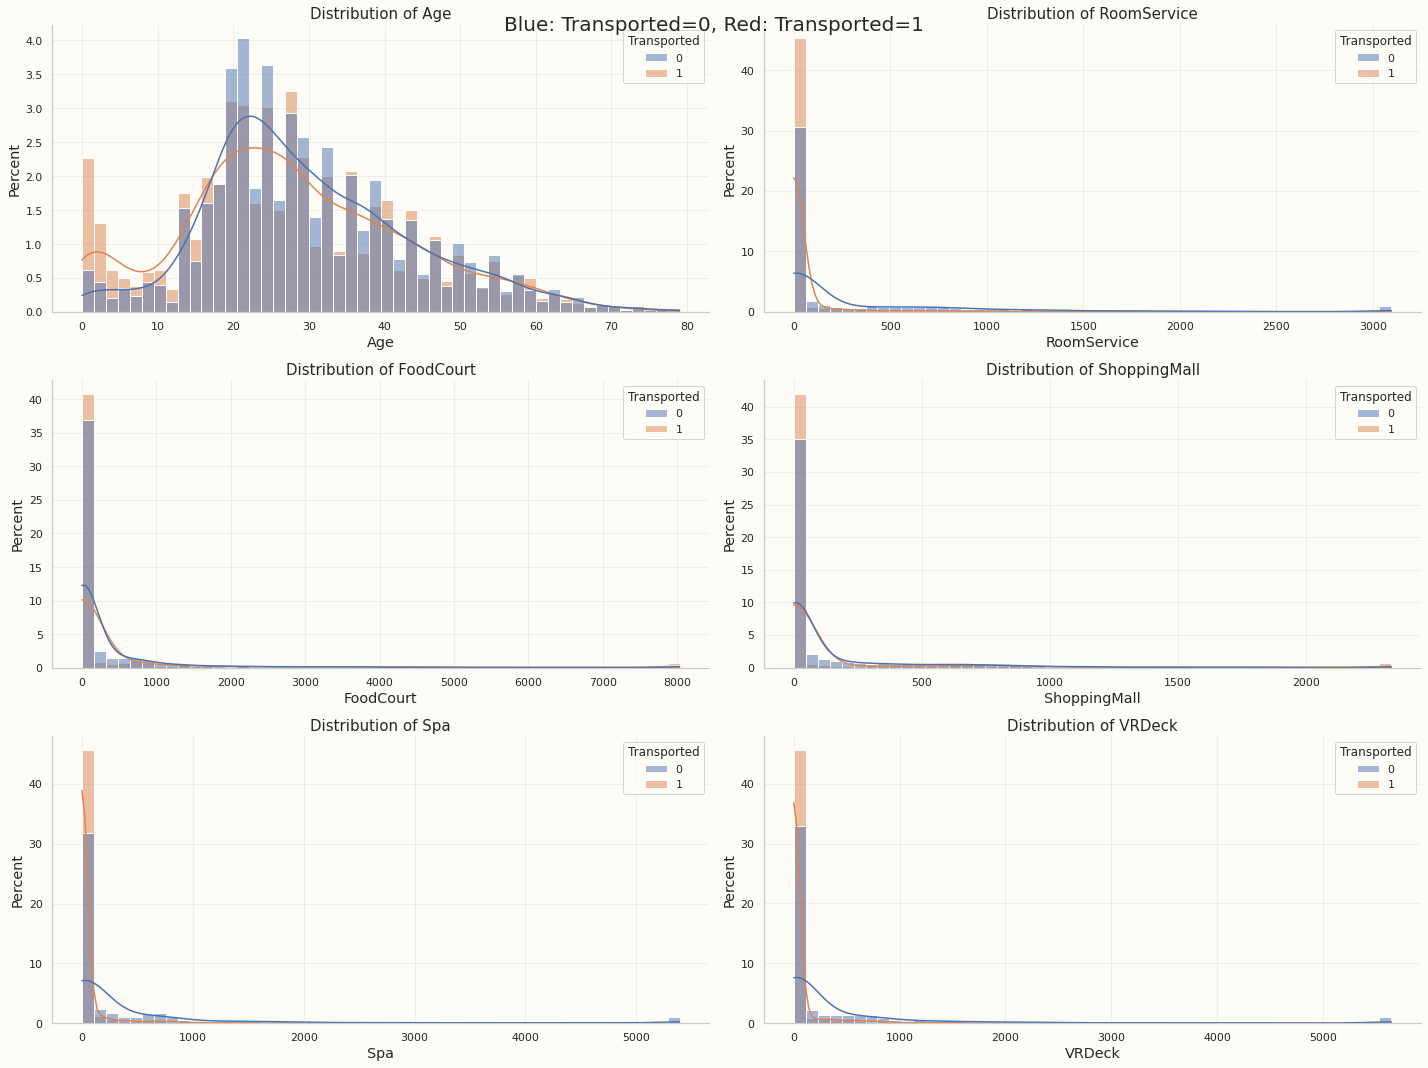

In [ ]:
## Distribution of Numerical Features after Clipping Outliers
n_cols = 2
n_rows = int(np.ceil(len(numerical_columns) / n_cols))

fig, axes = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(20,15))

bins = 50
for i, column in enumerate(numerical_columns):
    q, mod = divmod(i, n_cols)
    sns.histplot(x=column, data=train,
                 hue='Transported', ax=axes[q][mod],
                 bins=bins, stat="percent",
                 kde=True, legend=True)
    axes[q][mod].set_title(f'Distribution of {numerical_columns[i]}',size=15)
    
fig.suptitle('Blue: Transported=0, Red: Transported=1', fontsize=20)
fig.tight_layout()
plt.show()

In [ ]:
## Heat Map of Correlation Matrix
fig = px.imshow(
    train.corr(),
    color_continuous_scale='RdBu_r',
    color_continuous_midpoint=0, 
    aspect='auto'
)

fig.update_layout(
    height=500, 
    width=500,
    title="Heatmap",
    showlegend=False
)

fig.show()

In [ ]:
## Helper Functions
def bin_split(dataframe, column, n_bins, thresholds=None):
    if thresholds is None:
        if column == 'Age':
            bins = np.array([i*5 for i in range(21)])
        else:
            bins = np.array([-1, ])
            x = dataframe[column]
            x_quantiles = x.quantile([0, 0.9, 0.95, 0.99, 1])
            bins = np.append(bins, [i * ((x_quantiles.iloc[1] - x_quantiles.iloc[0]) / (n_bins-4)) for i in range(n_bins-4)])
            bins = np.append(bins, [x_quantiles.iloc[1], x_quantiles.iloc[2], x_quantiles.iloc[3], x_quantiles.iloc[4]+1])
    else:
        bins = thresholds[column]
        
    splits = pd.cut(dataframe[column], bins=bins, labels=False, right=True)
    return splits, bins

def binning(dataframe, numerical_columns, n_bins, thresholds=None):
    df = dataframe.copy()
    df_split_bins = {}
    for num_column in numerical_columns:
        splits, bins = bin_split(df, num_column, n_bins, thresholds)
        df[num_column] = splits
        df_split_bins[num_column] = bins    
    return df, df_split_bins

n_bins = exp_config['n_bins']
train, train_split_bins = binning(train, numerical_columns, n_bins, thresholds=None)

for key in train_split_bins:
    print(f'{key} bins: \n{train_split_bins[key]}\n\n')

Age bins: 
[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


RoomService bins: 
[-1.0000000e+00  0.0000000e+00  1.2550000e+02  2.5100000e+02
  3.7650000e+02  5.0200000e+02  6.2750000e+02  7.5300000e+02
  1.2742500e+03  3.0955447e+03  3.0972300e+03]


FoodCourt bins: 
[-1.0000000e+00  0.0000000e+00  1.7100000e+02  3.4200000e+02
  5.1300000e+02  6.8400000e+02  8.5500000e+02  1.0260000e+03
  2.7485000e+03  8.0299521e+03  8.0343100e+03]


ShoppingMall bins: 
[-1.00000000e+00  0.00000000e+00  1.03266667e+02  2.06533333e+02
  3.09800000e+02  4.13066667e+02  5.16333333e+02  6.19600000e+02
  9.27800000e+02  2.33223040e+03  2.33444000e+03]


Spa bins: 
[-1.000000e+00  0.000000e+00  1.220000e+02  2.440000e+02  3.660000e+02
  4.880000e+02  6.100000e+02  7.320000e+02  1.607100e+03  5.389281e+03
  5.391100e+03]


VRDeck bins: 
[-1.0000000e+00  0.0000000e+00  1.2210000e+02  2.4420000e+02
  3.6630000e+02  4.8840000e+02  6.1050000e+02  7.3260000e+02
  1.5342000e+

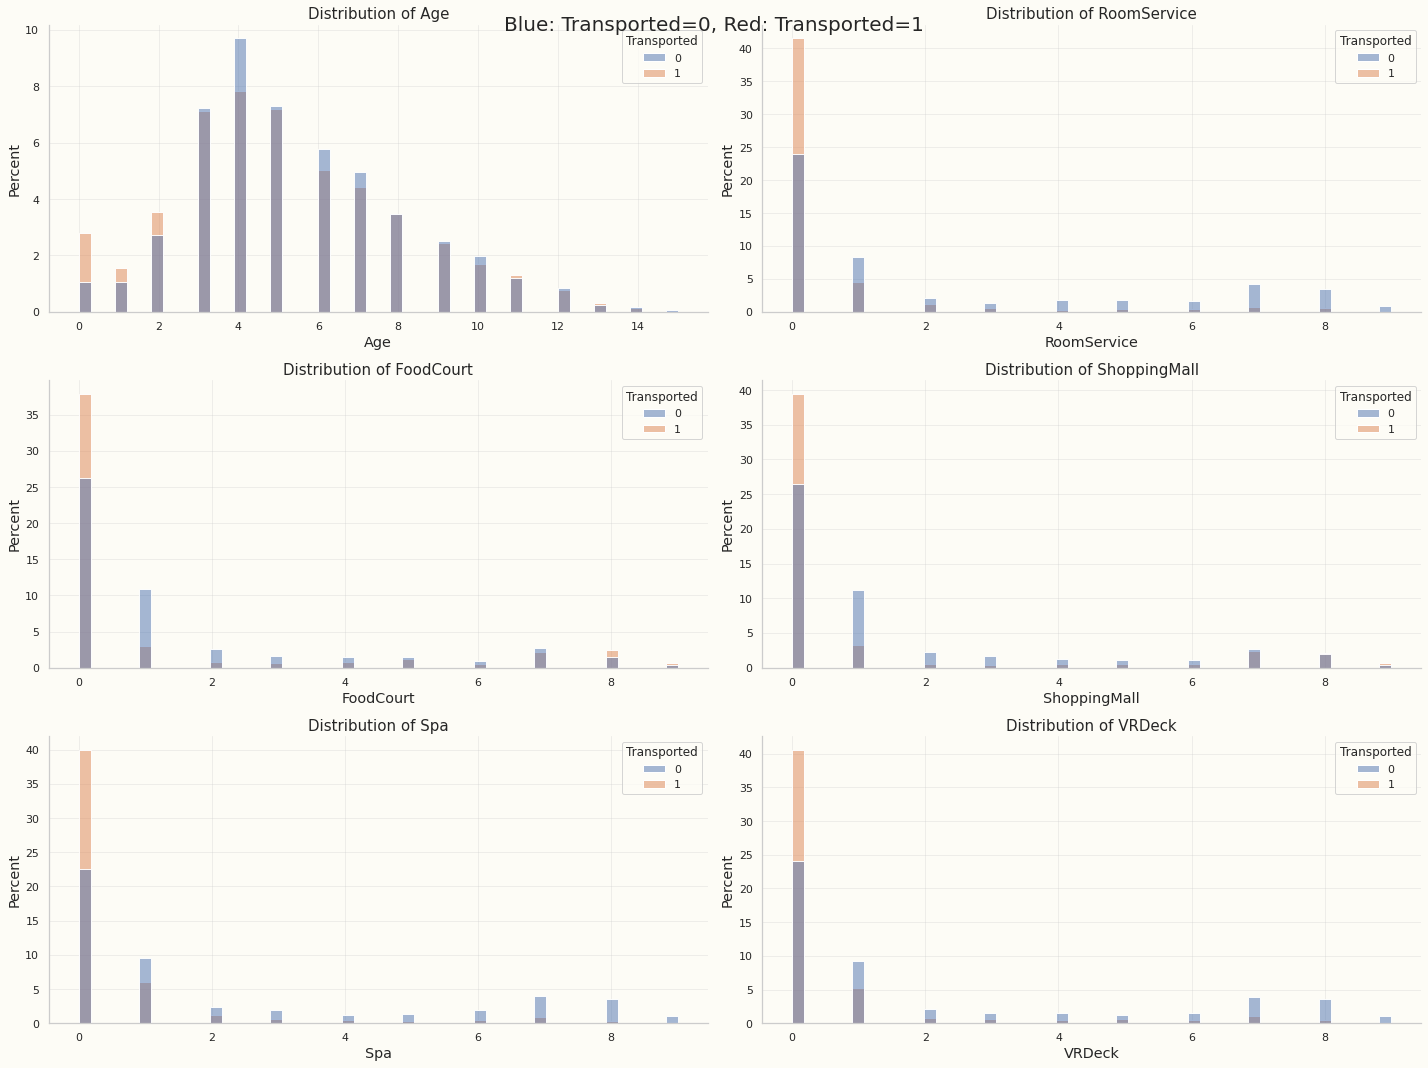

In [ ]:
## Distribution of Numerical Features after Binning
n_cols = 2
n_rows = int(np.ceil(len(numerical_columns) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,15))

bins = 50
for i, column in enumerate(numerical_columns):
    q, mod = divmod(i, n_cols)
    sns.histplot(
        x=column, 
        data=train, 
        hue='Transported', 
        ax=axes[q][mod], 
        bins=bins, 
        stat="percent", 
        legend=True
    )
    axes[q][mod].set_title(f'Distribution of {numerical_columns[i]}',size=15)
    
fig.suptitle('Blue: Transported=0, Red: Transported=1', fontsize=20)
fig.tight_layout()
plt.show()

In [ ]:
## Distribution of Categorical Features
categorical_columns = ['HomePlanet', 'CryoSleep',
                       'Destination', 'VIP']

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=categorical_columns,
    shared_yaxes='all'
)

for i in range(2):
    for j in range(2):
        n = i*2 + j
        data0 = go.Histogram(
            x=train_neg[categorical_columns[n]],
            marker = dict(color='#0000FF'), ## Blue
            name='Transporetd=0'
        )
        data1 = go.Histogram(
            x=train_pos[categorical_columns[n]],
            marker = dict(color='#FF0000'), ## Red
            name='Transported=1'
        )
        
        fig.add_trace(data0, row=i+1, col=j+1)
        fig.add_trace(data1, row=i+1, col=j+1)
        
        fig.update_traces(opacity=0.75, histnorm='probability')
        #fig.update_layout(barmode='overlay')

fig.update_layout(title = dict(text='Blue: Transported=0, Red: Transported=1'),
                  showlegend=False,)
fig.update_yaxes(title='probability', row=1, col=1)
fig.update_yaxes(title='probability', row=2, col=1)
fig.show()

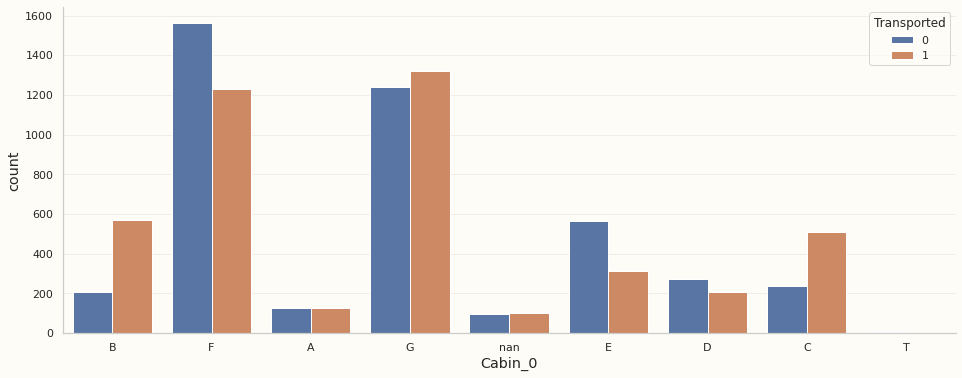

In [ ]:
## 'Cabin_0'
sns.countplot(x='Cabin_0', data=train, hue='Transported')

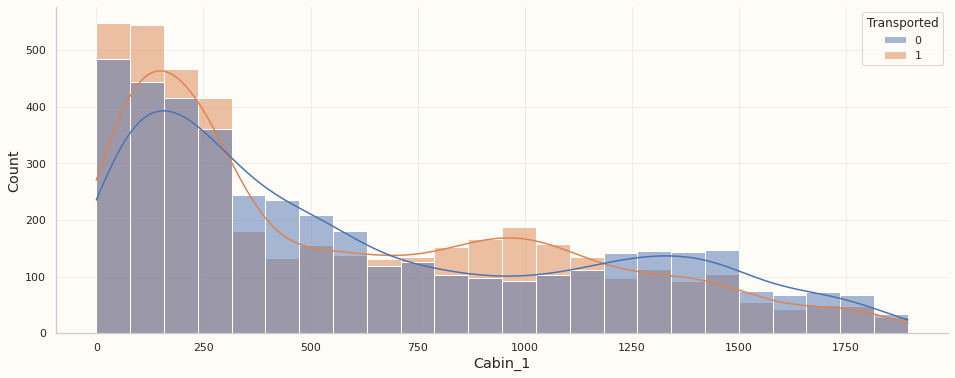

In [ ]:
## 'Cabin_1'
sns.histplot(x='Cabin_1', data=train, hue='Transported', kde=True)

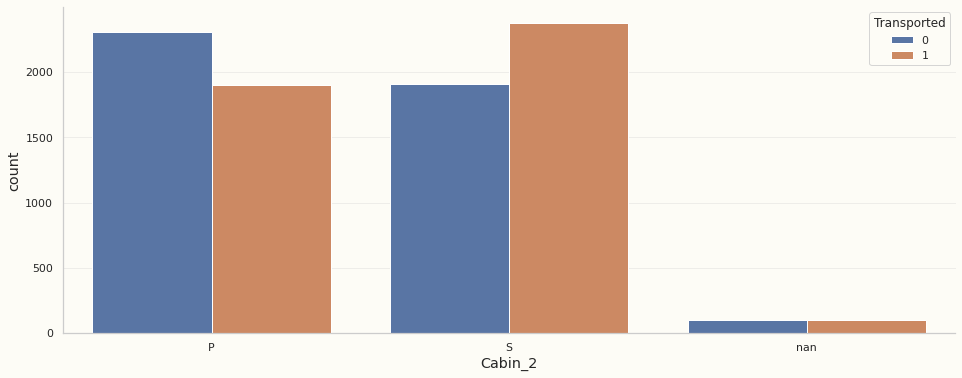

In [ ]:
## 'Cabin_2'
sns.countplot(x='Cabin_2', data=train, hue='Transported')

In [ ]:
## Histogram of 'Cabin_1' by Plotly (interactive)
fig = go.Figure()

data0 = go.Histogram(
    x=train_neg['Cabin_1'],
    marker = dict(color='#0000FF'), # Blue
    opacity=0.6,
    name='Transporetd=0'
)
data1 = go.Histogram(
    x=train_pos['Cabin_1'],
    marker = dict(color='#FF0000'), # Red
    opacity=0.6,
    name='Transported=1'
)

fig.add_trace(data0)
fig.add_trace(data1)

fig.update_layout(
    xaxis = dict(title='Cabin_1'),
    yaxis = dict(title='Count')
)
fig.update_layout(barmode='overlay')

fig.show()

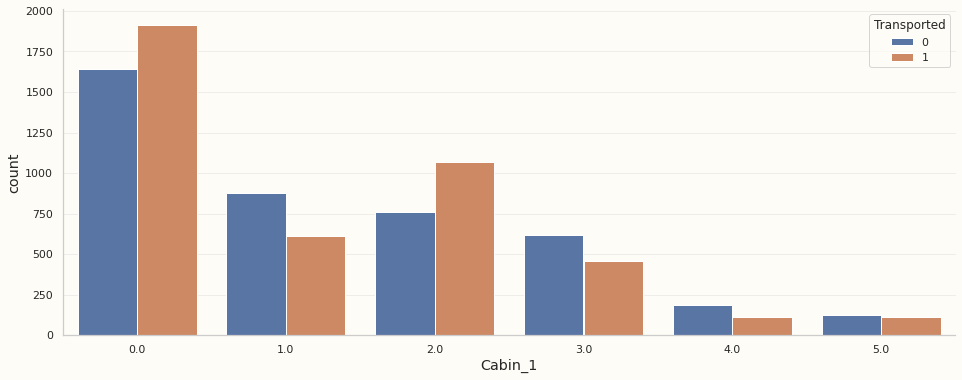

In [ ]:
## Binning 'Cabin_1' based on the above graph
cabin_1_bins = np.array([0, 300, 600, 1150, 1500, 1700, 2000])
train['Cabin_1'] = pd.cut(train['Cabin_1'], bins=cabin_1_bins, labels=False, right=False)

## Distribution of 'Cabin_1' after Binning
sns.countplot(x='Cabin_1', data=train, hue='Transported')

In [ ]:
numerical_columns_0 = ['Age', 'RoomService', 'FoodCourt',
                     'ShoppingMall', 'Spa', 'VRDeck']
numerical_columns_1 = ['Age', 'RoomService', 'FoodCourt',
                     'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_1']
categorical_columns_0 = ['PassengerId', 'HomePlanet', 'CryoSleep',
                       'Cabin', 'Destination', 'VIP', 'Name']
categorical_columns_1 = ['PassengerId', 'HomePlanet', 'CryoSleep',
                       'Cabin', 'Destination', 'VIP', 'Name',
                       'Cabin_0', 'Cabin_2']

In [ ]:
## Before filling null values,　making the string 'nan' (transformed by astype(str) in preprocess_df() function) back to np.nan.
for column in ['CryoSleep', 'VIP', 'HomePlanet', 'Destination', 'Cabin_0', 'Cabin_2']:
    train[column] = train[column].map(lambda x: np.nan if x=='nan' else x)

## Filling null values with mode
train = train.fillna(train.mode().iloc[0])

for numerical in numerical_columns_1:
    train[numerical] = train[numerical].astype('int64')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PassengerId   8693 non-null   object
 1   HomePlanet    8693 non-null   object
 2   CryoSleep     8693 non-null   object
 3   Destination   8693 non-null   object
 4   Age           8693 non-null   int64 
 5   VIP           8693 non-null   object
 6   RoomService   8693 non-null   int64 
 7   FoodCourt     8693 non-null   int64 
 8   ShoppingMall  8693 non-null   int64 
 9   Spa           8693 non-null   int64 
 10  VRDeck        8693 non-null   int64 
 11  Transported   8693 non-null   int64 
 12  Cabin_0       8693 non-null   object
 13  Cabin_1       8693 non-null   int64 
 14  Cabin_2       8693 non-null   object
dtypes: int64(8), object(7)
memory usage: 1018.8+ KB


In [ ]:
## Test Data Processing
test = preprocess_df(test_df)
test = cabin_split(test)

test = clipping_quantile(test, quantile_values=train_quantile_values.loc[0.99])
test, _ = binning(test, numerical_columns_0, n_bins, thresholds=train_split_bins)
test['Cabin_1'] = pd.cut(test['Cabin_1'], bins=cabin_1_bins, labels=False, right=False)

for column in ['CryoSleep', 'VIP', 'HomePlanet', 'Destination', 'Cabin_0', 'Cabin_2']:
    test[column] = test[column].map(lambda x: np.nan if x=='nan' else x)

test = test.fillna(train.mode().iloc[0])

for numerical in numerical_columns_1:
    test[numerical] = test[numerical].astype('int64')

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PassengerId   4277 non-null   object
 1   HomePlanet    4277 non-null   object
 2   CryoSleep     4277 non-null   object
 3   Destination   4277 non-null   object
 4   Age           4277 non-null   int64 
 5   VIP           4277 non-null   object
 6   RoomService   4277 non-null   int64 
 7   FoodCourt     4277 non-null   int64 
 8   ShoppingMall  4277 non-null   int64 
 9   Spa           4277 non-null   int64 
 10  VRDeck        4277 non-null   int64 
 11  Cabin_0       4277 non-null   object
 12  Cabin_1       4277 non-null   int64 
 13  Cabin_2       4277 non-null   object
dtypes: int64(7), object(7)
memory usage: 467.9+ KB


In [ ]:
## Split train samples for cross-validation
n_splits = exp_config['n_splits']
skf = StratifiedKFold(n_splits=n_splits)
train['k_folds'] = -1
for fold, (train_idx, valid_idx) in enumerate(
    skf.split(X=train, y=train['Transported'])
):
    train['k_folds'][valid_idx] = fold
    
## Check split samples
for i in range(n_splits):
    print(f"fold {i}: {len(train.query('k_folds==@i'))} samples")

fold 0: 1739 samples
fold 1: 1739 samples
fold 2: 1739 samples
fold 3: 1738 samples
fold 4: 1738 samples


In [ ]:
## Hold-out validation
valid_fold = train.query(f'k_folds == 0').reset_index(drop=True)
train_fold = train.query(f'k_folds != 0').reset_index(drop=True)
print(len(train_fold), len(valid_fold))

6954 1739


In [ ]:
## After binning, all features are categorical.
numerical_columns = []
categorical_columns = ['Age', 'RoomService', 'FoodCourt',
                       'ShoppingMall', 'Spa', 'VRDeck',
                       'HomePlanet', 'CryoSleep',
                       'Destination', 'VIP', 
                       'Cabin_0', 'Cabin_1', 'Cabin_2']

## Making Lookup table of categorical featurs and target
## Using sklearn.preprocessing.OrdinalEncoder
oe = OrdinalEncoder(handle_unknown='error',
                    dtype=np.int64)

encoded = oe.fit_transform(train_fold[categorical_columns].values)
#decoded = oe.inverse_transform(encoded)
train_fold[categorical_columns] = encoded

valid_fold[categorical_columns] = oe.transform(valid_fold[categorical_columns].values)
train[categorical_columns] = oe.transform(train[categorical_columns].values)
test[categorical_columns] = oe.transform(test[categorical_columns].values)

encoder_categories = oe.categories_
encoder_categories

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object),
 array(['Earth', 'Europa', 'Mars'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], dtype=object),
 array([0, 1, 2, 3, 4, 5], dtype=object),
 array(['P', 'S'], dtype=object)]

In [ ]:
## Dataset
class SpaceshipDataset(torch.utils.data.Dataset):
    def __init__(self, df, numerical_columns,
                 categorical_columns, target=None):
        self.df = df
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.target = target
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        data = {}
        
        for nc in self.numerical_columns:
            x = torch.tensor(self.df[nc][index],
                             dtype=torch.float32)
            x = torch.unsqueeze(x, dim=0)
            data[nc] = x
            
        for cc in self.categorical_columns:
            x = torch.tensor(self.df[cc][index],
                             dtype=torch.int32)
            x = torch.unsqueeze(x, dim=0)
            data[cc] = x
        
        if self.target is not None:
            label = torch.tensor(self.df[self.target][index],
                                 dtype=torch.float32)
            label = torch.unsqueeze(label, dim=-1)
            return data, label
        else:
            return data

In [ ]:
## Create Datasets
train_ds = SpaceshipDataset(
    train_fold,
    numerical_columns,
    categorical_columns,
    target='Transported'
)

val_ds = SpaceshipDataset(
    valid_fold,
    numerical_columns, 
    categorical_columns, 
    target='Transported'
)

test_ds = SpaceshipDataset(
    test,
    numerical_columns, 
    categorical_columns,
    target=None
)

## Operation Check
index = 0
print(train_ds.__getitem__(index))

({'Age': tensor([10], dtype=torch.int32), 'RoomService': tensor([5], dtype=torch.int32), 'FoodCourt': tensor([0], dtype=torch.int32), 'ShoppingMall': tensor([0], dtype=torch.int32), 'Spa': tensor([3], dtype=torch.int32), 'VRDeck': tensor([1], dtype=torch.int32), 'HomePlanet': tensor([0], dtype=torch.int32), 'CryoSleep': tensor([0], dtype=torch.int32), 'Destination': tensor([2], dtype=torch.int32), 'VIP': tensor([0], dtype=torch.int32), 'Cabin_0': tensor([6], dtype=torch.int32), 'Cabin_1': tensor([0], dtype=torch.int32), 'Cabin_2': tensor([1], dtype=torch.int32)}, tensor([0.]))


In [ ]:
## Create DataLoaders
batch_size = exp_config['batch_size']

train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True
)
val_dl = torch.utils.data.DataLoader(
    val_ds, 
    batch_size=batch_size, 
    shuffle=True
)
test_dl = torch.utils.data.DataLoader(
    test_ds, 
    batch_size=batch_size, 
    shuffle=False, 
    drop_last=False
)

dl_dict = {'train': train_dl, 'val': val_dl}

## Operation Check
sample_data, sample_label = next(iter(dl_dict['train']))
input_dtypes = {}
for key in sample_data:
    input_dtypes[key] = sample_data[key].dtype
    print(f'{key}, shape:{sample_data[key].shape}, dtype:{sample_data[key].dtype}')

print('Label shape: ', sample_label.shape)

Age, shape:torch.Size([512, 1]), dtype:torch.int32
RoomService, shape:torch.Size([512, 1]), dtype:torch.int32
FoodCourt, shape:torch.Size([512, 1]), dtype:torch.int32
ShoppingMall, shape:torch.Size([512, 1]), dtype:torch.int32
Spa, shape:torch.Size([512, 1]), dtype:torch.int32
VRDeck, shape:torch.Size([512, 1]), dtype:torch.int32
HomePlanet, shape:torch.Size([512, 1]), dtype:torch.int32
CryoSleep, shape:torch.Size([512, 1]), dtype:torch.int32
Destination, shape:torch.Size([512, 1]), dtype:torch.int32
VIP, shape:torch.Size([512, 1]), dtype:torch.int32
Cabin_0, shape:torch.Size([512, 1]), dtype:torch.int32
Cabin_1, shape:torch.Size([512, 1]), dtype:torch.int32
Cabin_2, shape:torch.Size([512, 1]), dtype:torch.int32
Label shape:  torch.Size([512, 1])


In [ ]:
class Preprocessor(nn.Module):
    def __init__(self, numerical_columns, categorical_columns, encoder_categories, emb_dim):
        super().__init__()
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.encoder_categories = encoder_categories
        self.emb_dim = emb_dim
        self.embed_layers = nn.ModuleDict()
        
        for i, categorical in enumerate(categorical_columns):
            embedding = nn.Embedding(
                num_embeddings=len(self.encoder_categories[i]),
                embedding_dim=self.emb_dim,
            )
            self.embed_layers[categorical] = embedding
            
    def forward(self, x):
        x_nums = []
        for numerical in self.numerical_columns:
            x_num = torch.unsqueeze(x[numerical], dim=1)
            x_nums.append(x_num)
        if len(x_nums) > 0:
            x_nums = torch.cat(x_nums, dim=1)
        else:
            x_nums = torch.tensor(x_nums, dtype=torch.float32)
        
        x_cats = []
        for categorical in self.categorical_columns:
            x_cat = self.embed_layers[categorical](x[categorical])
            x_cats.append(x_cat)
        if len(x_cats) > 0:
            x_cats = torch.cat(x_cats, dim=1)
        else:
            x_cats = torch.tensor(x_cats, dtype=torch.float32)
        
        return x_nums, x_cats
    
## Operation Check
preprocessor = Preprocessor(
    numerical_columns,
    categorical_columns,
    encoder_categories,
    emb_dim=3)
x_nums, x_cats = preprocessor(sample_data)
x_nums.shape, x_cats.shape

(torch.Size([0]), torch.Size([512, 13, 3]))

In [ ]:
class MLPBlock(nn.Module):
    def __init__(self, n_features, hidden_units,
                 dropout_rates):
        super().__init__()
        self.mlp_layers = nn.Sequential()
        num_features = n_features
        for i, units in enumerate(hidden_units):
            self.mlp_layers.add_module(
                f'norm_{i}',
                nn.BatchNorm1d(num_features))
            self.mlp_layers.add_module(
                f'dense_{i}',
                nn.Linear(num_features, units))
            self.mlp_layers.add_module(
                f'act_{i}',
                nn.SELU())
            self.mlp_layers.add_module(
                f'dropout_{i}',
                nn.Dropout(dropout_rates[i]))
            num_features = units
            
    def forward(self, x):
        y = self.mlp_layers(x)
        return y

In [ ]:
class TabTransformerBlock(nn.Module):
    def __init__(self, num_heads, emb_dim,
                 attn_dropout_rate, ff_dropout_rate):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            emb_dim, num_heads,
            dropout=attn_dropout_rate,
            batch_first=True)
        self.norm_1 = nn.LayerNorm(emb_dim)
        self.norm_2 = nn.LayerNorm(emb_dim)
        self.feedforward = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*4),
            nn.GELU(),
            nn.Dropout(ff_dropout_rate), 
            nn.Linear(emb_dim*4, emb_dim))
        
    def forward(self, x_cat):
        attn_output, attn_output_weights = self.attn(x_cat, x_cat, x_cat)
        x_skip_1 = x_cat + attn_output
        x_skip_1 = self.norm_1(x_skip_1)
        feedforward_output = self.feedforward(x_skip_1)
        x_skip_2 = x_skip_1 + feedforward_output
        x_skip_2 = self.norm_2(x_skip_2)
        return x_skip_2

In [ ]:
class OriginalTabTransformer(nn.Module): 
    def __init__(self, numerical_columns, categorical_columns,
                 num_transformer_blocks, num_heads, emb_dim,
                 attn_dropout_rates, ff_dropout_rates,
                 mlp_dropout_rates,
                 mlp_hidden_units_factors,
                 ):
        super().__init__()
        self.transformers = nn.Sequential()
        for i in range(num_transformer_blocks):
            self.transformers.add_module(
                f'transformer_{i}', 
                TabTransformerBlock(
                    num_heads,
                    emb_dim,
                    attn_dropout_rates[i],
                    ff_dropout_rates[i]))
        
        self.flatten = nn.Flatten()
        self.num_norm = nn.LayerNorm(len(numerical_columns))
        
        self.n_features = (len(categorical_columns) * emb_dim) + len(numerical_columns)
        mlp_hidden_units = [int(factor * self.n_features) \
                            for factor in mlp_hidden_units_factors]
        self.mlp = MLPBlock(
            self.n_features, mlp_hidden_units,
            mlp_dropout_rates)
        
        self.final_dense = nn.Linear(mlp_hidden_units[-1], 1)
        self.final_sigmoid = nn.Sigmoid()
        
    def forward(self, x_nums, x_cats):
        contextualized_x_cats = self.transformers(x_cats)
        contextualized_x_cats = self.flatten(contextualized_x_cats)
        
        if x_nums.shape[-1] > 0:
            x_nums = self.num_norm(x_nums)
            features = torch.cat((x_nums, contextualized_x_cats), -1)
        else:
            features = contextualized_x_cats
            
        mlp_output = self.mlp(features)
        model_output = self.final_dense(mlp_output)
        output = self.final_sigmoid(model_output)
        return output

In [ ]:
class ModifiedTabTransformer(nn.Module): 
    def __init__(self, numerical_columns, categorical_columns,
                 num_transformer_blocks, num_heads, emb_dim,
                 attn_dropout_rates, ff_dropout_rates,
                 mlp_dropout_rates,
                 mlp_hidden_units_factors,
                 ):
        super().__init__()
        
        if len(numerical_columns) > 0:
            self.num_norm = nn.LayerNorm(len(numerical_columns))
            self.num_proj = nn.Sequential()
            self.num_proj.add_module(
                f'expansion',
                nn.Linear(
                    len(numerical_columns), 
                    len(numerical_columns)*num_proj_factor))
            self.num_proj.add_module(
                f'activation', 
                nn.GELU())
            self.num_proj.add_module(
                f'squeeze', 
                nn.Linear(
                    len(numerical_columns)*num_proj_factor, 
                    emb_dim))
            seq_len = len(categorical_columns) + 1
        else:
            seq_len = len(categorical_columns)
            
        self.transformers = nn.Sequential()
        for i in range(num_transformer_blocks):
            self.transformers.add_module(
                f'transformer_{i}', 
                TabTransformerBlock(
                    num_heads,
                    emb_dim,
                    attn_dropout_rates[i],
                    ff_dropout_rates[i]))
        
        self.flatten = nn.Flatten()
        
        n_features = seq_len * emb_dim
        self.mlp = None
        if len(mlp_hidden_units_factors) > 0:
            mlp_hidden_units = [int(factor * n_features)\
                                for factor in mlp_hidden_units_factors]
            self.mlp = MLPBlock(
                n_features,
                mlp_hidden_units,
                mlp_dropout_rates)
            self.final_dense = nn.Linear(mlp_hidden_units[-1], 1)
        else:
            self.final_dense = nn.Linear(n_features, 1)
            
        self.final_sigmoid = nn.Sigmoid()
        
    def forward(self, x_nums, x_cats):
        if x_nums.shape[-1] > 0:
            x_nums = self.num_norm(x_nums)
            x_nums = self.num_proj(x_nums)
            x_nums = torch.unsqueeze(x_nums, dim=-2)
            features = torch.cat((x_nums, x_cats), dim=-2)
        else:
            features = x_cats
        
        contextualized_features = self.transformers(features)
        contextualized_features = self.flatten(contextualized_features)
        
        if self.mlp is not None:
            mlp_output = self.mlp(contextualized_features)
            model_output = self.final_dense(mlp_output)
        else:
            model_output = self.final_dense(contextualized_features)
        output = self.final_sigmoid(model_output)
        return output

In [ ]:
## TabTransformer Model Check

## Settings for TabTransformer
emb_dim = model_config['cat_embedding_dim']
num_transformer_blocks = model_config['num_transformer_blocks']
num_heads = model_config['num_heads']
attn_dropout_rates = model_config['tf_dropout_rates']
ff_dropout_rates = model_config['ff_dropout_rates']
mlp_dropout_rates = model_config['mlp_dropout_rates']
mlp_hidden_units_factors = model_config['mlp_hidden_units_factors']

## Building Models
preprocessor = Preprocessor(
    numerical_columns, categorical_columns,
    encoder_categories, emb_dim)

model = ModifiedTabTransformer(
    numerical_columns, categorical_columns,
    num_transformer_blocks, num_heads, emb_dim,
    attn_dropout_rates, ff_dropout_rates,
    mlp_dropout_rates, mlp_hidden_units_factors)

## Operation, Parameters and Model Structure Check
x_nums, x_cats = preprocessor(sample_data)
y = model(x_nums, x_cats)
print('Numerical Input shape: ', x_nums.shape)
print('Categorical Input shape: ', x_cats.shape)
print('Output shape: ', y.shape)

print('# of Preprocessor parameters: ',
      sum(p.numel() for p in preprocessor.parameters() if p.requires_grad))
print('# of TabTransformer parameters: ',
      sum(p.numel() for p in model.parameters() if p.requires_grad))

model

Numerical Input shape:  torch.Size([0])
Categorical Input shape:  torch.Size([512, 13, 12])
Output shape:  torch.Size([512, 1])
# of Preprocessor parameters:  1104
# of TabTransformer parameters:  32497


ModifiedTabTransformer(
  (transformers): Sequential(
    (transformer_0): TabTransformerBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
      )
      (norm_1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_features=12, out_features=48, bias=True)
        (1): GELU(approximate=none)
        (2): Dropout(p=0.0, inplace=False)
        (3): Linear(in_features=48, out_features=12, bias=True)
      )
    )
    (transformer_1): TabTransformerBlock(
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
      )
      (norm_1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
      (norm_2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_

In [ ]:
class SGUBlock(nn.Module):
    def __init__(self, seq_len, emb_dim,
                 split=True, init_eps=1e-3):
        super().__init__()
        self.split = split
        if self.split:
            self.norm = nn.LayerNorm(emb_dim//2)
        else:
            self.norm = nn.LayerNorm(emb_dim)
        self.W = nn.Parameter(torch.zeros(seq_len, seq_len))
        nn.init.uniform_(self.W, -init_eps, init_eps)
        if self.split:
            self.b = nn.Parameter(torch.ones((seq_len, emb_dim//2)))
        else:
            self.b = nn.Parameter(torch.ones((seq_len, emb_dim)))
        
    def forward(self, Z):
        if self.split:
            if Z.shape[-1] % 2 == 1:
                chunk_dim = Z.shape[-1] // 2
                Z1, Z2, _ = Z.split(chunk_dim, dim=-1)
            else:
                Z1, Z2 = torch.chunk(Z, 2, dim=-1)
            f_Z = self.norm(Z2)
        else:
            Z1 = Z
            f_Z = self.norm(Z)
        f_Z = torch.permute(f_Z, (0, 2, 1))
        f_Z = torch.matmul(f_Z, self.W)
        f_Z = torch.permute(f_Z, (0, 2, 1))
        f_Z = f_Z + self.b
        output = torch.mul(f_Z, Z1)
        return output

In [ ]:
class GMLPBlock(nn.Module):
    def __init__(self, seq_len, emb_dim,
                 num_blocks=2, split=True, 
                 proj_factor=4,
                 init_eps=1e-3):
        super().__init__()
        self.num_blocks = num_blocks
        self.gmlp = nn.ModuleList()
        for i in range(num_blocks):
            gmlp_block = nn.Sequential()
            gmlp_block.add_module(
                f'norm_{i}',
                nn.LayerNorm(emb_dim))
            gmlp_block.add_module(
                f'linear_{i}_1',
                nn.Linear(emb_dim,
                          emb_dim * proj_factor))
            gmlp_block.add_module(
                f'activation_{i}',
                nn.ReLU())
            gmlp_block.add_module(
                f'sgu_{i}',
                SGUBlock(seq_len,
                         emb_dim * proj_factor,
                         split))
            
            if split:
                tmp_dim = emb_dim * proj_factor // 2
            else:
                tmp_dim = emb_dim * proj_factor 
            
            gmlp_block.add_module(
                f'linear_{i}_2',
                nn.Linear(tmp_dim, emb_dim))
            self.gmlp.append(gmlp_block)
            
    def forward(self, x):
        for i in range(self.num_blocks):
            shortcut = x
            x = self.gmlp[i](x)
            x = x + shortcut
        return x

In [ ]:
class GMLP(nn.Module): 
    def __init__(self, numerical_columns, categorical_columns,
                 emb_dim, num_proj_factor=4,
                 gmlp_num_blocks=4, gmlp_split=True,
                 gmlp_proj_factor=4, 
                 gmlp_dropout=[0.], mlp_factors=[],
                 gmlp_init_eps=1e-3, feature_pooling=False,):
        super().__init__()
        
        if len(numerical_columns) > 0:
            self.num_norm = nn.LayerNorm(len(numerical_columns))
            self.num_proj = nn.Sequential()
            self.num_proj.add_module(
                f'expansion',
                nn.Linear(
                    len(numerical_columns), 
                    len(numerical_columns)*num_proj_factor))
            self.num_proj.add_module(
                f'activation', 
                nn.GELU())
            self.num_proj.add_module(
                f'squeeze', 
                nn.Linear(
                    len(numerical_columns)*num_proj_factor, 
                    emb_dim))
            seq_len = len(categorical_columns) + 1
        else:
            seq_len = len(categorical_columns)
        self.gmlp = GMLPBlock(
            seq_len, emb_dim,
            num_blocks=gmlp_num_blocks,
            split=gmlp_split, 
            proj_factor=gmlp_proj_factor,
            init_eps=gmlp_init_eps)
        
        self.feature_pooling = feature_pooling
        if feature_pooling:
            mlp_input_dim = emb_dim
        else:
            mlp_input_dim = seq_len * emb_dim
            self.flatten = nn.Flatten()
            
        self.mlp_units = None
        if len(mlp_factors) > 0:
            self.mlp_units = [factor * mlp_input_dim\
                              for factor in mlp_factors]
            
        if self.mlp_units is not None:
            self.mlp = nn.Sequential()
            input_dim = mlp_input_dim
            for i in range(len(self.mlp_units)):
                output_dim = self.mlp_units[i]
                self.mlp.add_module(
                    f'norm_{i}',
                    nn.BatchNorm1d(input_dim))
                self.mlp.add_module(
                    f'dense_{i}',
                    nn.Linear(input_dim, output_dim))
                self.mlp.add_module(
                    f'act_{i}',
                    nn.SELU())
                self.mlp.add_module(
                    f'dropout_{i}',
                    nn.Dropout(gmlp_dropout[i]))
                input_dim = output_dim
            self.final_dense = nn.Linear(
                input_dim, 1)
        else:
            self.final_dense = nn.Linear(
                mlp_input_dim, 1)
            
        self.final_sigmoid = nn.Sigmoid()
        
        
    def forward(self, x_nums, x_cats):
        if x_nums.shape[-1] > 0:
            x_nums = self.num_norm(x_nums)
            x_nums = self.num_proj(x_nums)
            x_nums = torch.unsqueeze(x_nums, dim=-2)
            features = torch.cat((x_nums, x_cats), dim=-2)
        else:
            features = x_cats
        gmlp_output = self.gmlp(features)
        
        if self.feature_pooling:
            gmlp_output = torch.mean(gmlp_output, dim=-2)
        else:
            gmlp_output = self.flatten(gmlp_output)
        
        if self.mlp_units is not None:
            gmlp_output = self.mlp(gmlp_output)
    
        model_output = self.final_dense(gmlp_output)
        output = self.final_sigmoid(model_output)
        return output

In [ ]:
## gMLP Model Check

## Settings for gMLP Model
emb_dim = model_config['cat_embedding_dim']
num_proj_factor = model_config['num_proj_factor']
gmlp_num_blocks = model_config['gmlp_num_blocks']
gmlp_split = model_config['gmlp_split']
gmlp_proj_factor = model_config['gmlp_proj_factor']
gmlp_dropout = model_config['gmlp_dropout']
mlp_factors = model_config['mlp_factors']
gmlp_init_eps = model_config['gmlp_init_eps']
feature_pooling = model_config['feature_pooling']

## Building Models
preprocessor = Preprocessor(
    numerical_columns, categorical_columns,
    encoder_categories, emb_dim)

model = GMLP(
    numerical_columns, categorical_columns,
    emb_dim, num_proj_factor=num_proj_factor,
    gmlp_num_blocks=gmlp_num_blocks,
    gmlp_split=gmlp_split,
    gmlp_proj_factor=gmlp_proj_factor,
    gmlp_dropout=gmlp_dropout,
    mlp_factors=mlp_factors,
    gmlp_init_eps=gmlp_init_eps,
    feature_pooling=feature_pooling)

## Operation, Parameters and Model Structure Check
x_nums, x_cats = preprocessor(sample_data)
y = model(x_nums, x_cats)
print('Numerical Input shape: ', x_nums.shape)
print('Categorical Input shape: ', x_cats.shape)
print('Output shape: ', y.shape)

print('# of Preprocessor parameters: ',\
      sum(p.numel() for p in preprocessor.parameters() if p.requires_grad))
print('# of gMLP parameters: ',\
      sum(p.numel() for p in model.parameters() if p.requires_grad))

model

Numerical Input shape:  torch.Size([0])
Categorical Input shape:  torch.Size([512, 13, 12])
Output shape:  torch.Size([512, 1])
# of Preprocessor parameters:  1104
# of gMLP parameters:  34927


GMLP(
  (gmlp): GMLPBlock(
    (gmlp): ModuleList(
      (0): Sequential(
        (norm_0): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (linear_0_1): Linear(in_features=12, out_features=36, bias=True)
        (activation_0): ReLU()
        (sgu_0): SGUBlock(
          (norm): LayerNorm((18,), eps=1e-05, elementwise_affine=True)
        )
        (linear_0_2): Linear(in_features=18, out_features=12, bias=True)
      )
      (1): Sequential(
        (norm_1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (linear_1_1): Linear(in_features=12, out_features=36, bias=True)
        (activation_1): ReLU()
        (sgu_1): SGUBlock(
          (norm): LayerNorm((18,), eps=1e-05, elementwise_affine=True)
        )
        (linear_1_2): Linear(in_features=18, out_features=12, bias=True)
      )
      (2): Sequential(
        (norm_2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
        (linear_2_1): Linear(in_features=12, out_features=36, bias=True)
        

In [ ]:
## Building Models
preprocessor = Preprocessor(
    numerical_columns, categorical_columns,
    encoder_categories, emb_dim)

if model_config['model'] == 'tabtransformer':
    model = ModifiedTabTransformer(
        numerical_columns, categorical_columns,
        num_transformer_blocks, num_heads, emb_dim,
        attn_dropout_rates, ff_dropout_rates,
        mlp_dropout_rates, mlp_hidden_units_factors)
    
elif model_config['model'] == 'gmlp':
    model = GMLP(
        numerical_columns, categorical_columns,
        emb_dim, num_proj_factor=num_proj_factor,
        gmlp_num_blocks=gmlp_num_blocks,
        gmlp_split=gmlp_split,
        gmlp_proj_factor=gmlp_proj_factor,
        gmlp_dropout=gmlp_dropout,
        mlp_factors=mlp_factors,
        gmlp_init_eps=gmlp_init_eps,
        feature_pooling=feature_pooling)

print(f"model: {model_config['model']}")

model: gmlp


In [ ]:
## Loss Function
criterion = nn.BCELoss()

## Optimizer and Learning Rate Scheduler
epochs = exp_config['train_epochs']
batch_size = exp_config['batch_size']
steps_per_epoch = len(train_fold) // batch_size

learning_rate = exp_config['learning_rate']
weight_decay = exp_config['weight_decay']
params = list(preprocessor.parameters()) + list(model.parameters())

optimizer = torch.optim.AdamW(
    params=params,
    lr=learning_rate,
    weight_decay=weight_decay)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=epochs*steps_per_epoch)

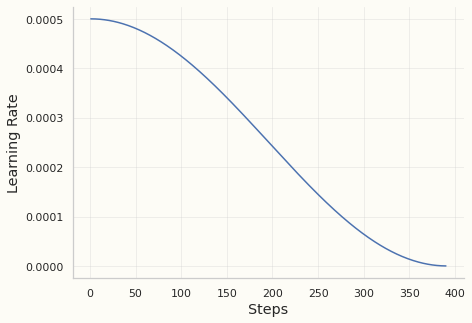

In [ ]:
## Displaying Learning Rate
def lr_plot(lr_scheduler, steps):
    lrs = []
    for _ in range(steps):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()
    xs = [i+1 for i in range(steps)]
    plt.figure(figsize=(7,5))
    ax = sns.lineplot(xs, lrs)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Learning Rate')
    
lr_plot(lr_scheduler, epochs*steps_per_epoch)

## Create New Optimizer and Lr_scheduler
optimizer = torch.optim.AdamW(
    params=params,
    lr=learning_rate,
    weight_decay=weight_decay)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=epochs*steps_per_epoch)

In [ ]:
## Model Save & Load
cpt_filepath = exp_config['checkpoint_filepath']

## Function for Saving Model
def model_save(model, preprocessor,
               optimizer, scheduler, path):
    directory = path.split('/')[:-1]
    directory = '/'.join(directory)
    os.makedirs(directory, exist_ok=True)
    
    ## When you use multi GPUs with DataParallel
    model_to_save = model.module if hasattr(model, "module") else model
    
    checkpoint = {
        "model": model_to_save.state_dict(),
        "preprocessor": preprocessor.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "random": random.getstate(),
        "np_random": np.random.get_state(),
        "torch": torch.get_rng_state(),
        "torch_random": torch.random.get_rng_state(),
    }
    
    if torch.cuda.is_available():
        cuda_random_state = {
            "cuda_random": torch.cuda.get_rng_state(),
            "cuda_random_all": torch.cuda.get_rng_state_all(),
        }
        checkpoint.update(cuda_random_state)
        
    torch.save(checkpoint, path)
    print('Model saved!')

## Function for Loading Model
def model_load(model, preprocessor,
               optimizer, scheduler, path):
    checkpoint = torch.load(path) 
    
    ## When you use multi GPUs with DataParallel
    if hasattr(model, "module"):  
        model.module.load_state_dict(checkpoint["model"])
    else:
        model.load_state_dict(checkpoint["model"])
        
    preprocessor.load_state_dict(checkpoint["preprocessor"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    random.setstate(checkpoint["random"])
    np.random.set_state(checkpoint["np_random"])
    torch.set_rng_state(checkpoint["torch"])
    torch.random.set_rng_state(checkpoint["torch_random"])
    
    if torch.cuda.is_available():
        torch.cuda.set_rng_state(checkpoint["cuda_random"])
        torch.cuda.torch.cuda.set_rng_state_all(checkpoint["cuda_random_all"])
        
    print('Model loaded!')

In [ ]:
## Function for the Model Training
def train_model(model, preprocessor, dl_dict,
                criterion, optimizer, lr_scheduler,
                num_epochs, cpt_filepath=None,
                finalize=False):
    ## Checking usability of GUP
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'device: {device}')
    print('-------Start Training-------')
    model.to(device)
    ## We use preprocessor on CPU
    
    ## training and validation loop
    if finalize:
        phases = ['train']
    else:
        phases = ['train', 'val']
        
    losses = {phase: [] for phase in phases}
    best_val_loss = 100.
    best_epoch = 1
    for epoch in range(num_epochs):
        for phase in phases:
            if phase == 'train':
                preprocessor.train()
                model.train()
            else:
                preprocessor.eval()
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for data, labels in tqdm(dl_dict[phase]):
                x_nums, x_cats = preprocessor(data)
                
                x_nums = x_nums.to(device)
                labels = labels.to(device)
                
                ## Optimizer Initialization
                optimizer.zero_grad()
                
                ## Forward Processing
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(x_nums, x_cats)
                    loss = criterion(outputs, labels)
                    preds = torch.where(outputs>0.5, 1., 0.)
                    
                    ## Backward Processing and Optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        lr_scheduler.step()
                        
                    epoch_loss += loss.item() * x_cats.size(0)
                    epoch_corrects += torch.sum(preds == labels)
            
            epoch_loss = epoch_loss / len(dl_dict[phase].dataset)
            losses[phase].append(epoch_loss)
            epoch_acc = epoch_corrects / len(dl_dict[phase].dataset)
            
            ## Saving the best Model
            if phase == 'val':
                if cpt_filepath is not None:
                    if epoch_loss < best_val_loss:
                        best_epoch = epoch + 1
                        best_val_loss = epoch_loss
                        model_save(
                            model, preprocessor,
                            optimizer, lr_scheduler,
                            cpt_filepath)
            
            ## Displaying results
            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.\
                  format(epoch+1, num_epochs, phase, epoch_loss, epoch_acc))
    
    if finalize:
    ## Saving finalized Model
        if cpt_filepath is not None:
            model_save(
                model, preprocessor, 
                optimizer, lr_scheduler,
                cpt_filepath)
        
    return model, preprocessor, losses, best_epoch

In [ ]:
## Training
model, preprocessor, losses, best_epoch = train_model(
    model,
    preprocessor,
    dl_dict,
    criterion,
    optimizer,
    lr_scheduler,
    epochs,
    cpt_filepath,
)

## Load the Best Model
model_load(model, preprocessor, optimizer, lr_scheduler, cpt_filepath)

device: cuda:0
-------Start Training-------


  0%|          | 0/14 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

weight_decay = 0.0001
batch_size = 128
num_epochs = 100
dropout_rate = 0.2
image_size = 32  # We'll resize input images to this size.
patch_size = 4  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 128  # Number of hidden units.
num_blocks = 4  # Number of blocks.

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

169001437/169001437 [==============================] - 2s 0us/step


In [ ]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(gMLPLayer, self).__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

In [ ]:
def build_classifier(blocks):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
gmlp_blocks = keras.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)


optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay,)
# Compile the model.
gmlp_classifier.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ])
# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    # Fit the model.
history = gmlp_classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

Epoch 1/100
352/352 [==============================] - 41s 97ms/step - loss: 3.8687 - acc: 0.1050 - top5-acc: 0.3096 - val_loss: 3.4648 - val_acc: 0.1698 - val_top5-acc: 0.4328 - lr: 0.0030
Epoch 2/100
352/352 [==============================] - 44s 125ms/step - loss: 3.3492 - acc: 0.1873 - top5-acc: 0.4653 - val_loss: 3.0690 - val_acc: 0.2488 - val_top5-acc: 0.5472 - lr: 0.0030
Epoch 3/100
352/352 [==============================] - 33s 95ms/step - loss: 3.0643 - acc: 0.2431 - top5-acc: 0.5397 - val_loss: 2.9087 - val_acc: 0.2850 - val_top5-acc: 0.5856 - lr: 0.0030
Epoch 4/100
352/352 [==============================] - 34s 97ms/step - loss: 2.8862 - acc: 0.2766 - top5-acc: 0.5821 - val_loss: 2.7531 - val_acc: 0.3070 - val_top5-acc: 0.6190 - lr: 0.0030
Epoch 5/100
352/352 [==============================] - 34s 96ms/step - loss: 2.7722 - acc: 0.2962 - top5-acc: 0.6116 - val_loss: 2.6178 - val_acc: 0.3388 - val_top5-acc: 0.6524 - lr: 0.0030
Epoch 6/100
352/352 [============================

In [ ]:
_, accuracy, top_5_accuracy = gmlp_classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 3s 10ms/step - loss: 1.8732 - acc: 0.5094 - top5-acc: 0.7948
Test accuracy: 50.94%
Test top 5 accuracy: 79.48%


**Tabular data implementation on Tab Transformer**

In [ ]:
pip install -U tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [ ]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [ ]:
test_data = test_data[1:]
test_data.income_bracket = test_data.income_bracket.apply(
    lambda value: value.replace(".", "")
)

In [ ]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [ ]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sorted(list(train_data["workclass"].unique())),
    "education": sorted(list(train_data["education"].unique())),
    "marital_status": sorted(list(train_data["marital_status"].unique())),
    "occupation": sorted(list(train_data["occupation"].unique())),
    "relationship": sorted(list(train_data["relationship"].unique())),
    "race": sorted(list(train_data["race"].unique())),
    "gender": sorted(list(train_data["gender"].unique())),
    "native_country": sorted(list(train_data["native_country"].unique())),
}
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "fnlwgt"
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "income_bracket"
# A list of the labels of the target features.
TARGET_LABELS = [" <=50K", " >50K"]

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [ ]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()

In [ ]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

In [ ]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [ ]:
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

In [ ]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

Total model weights: 109629


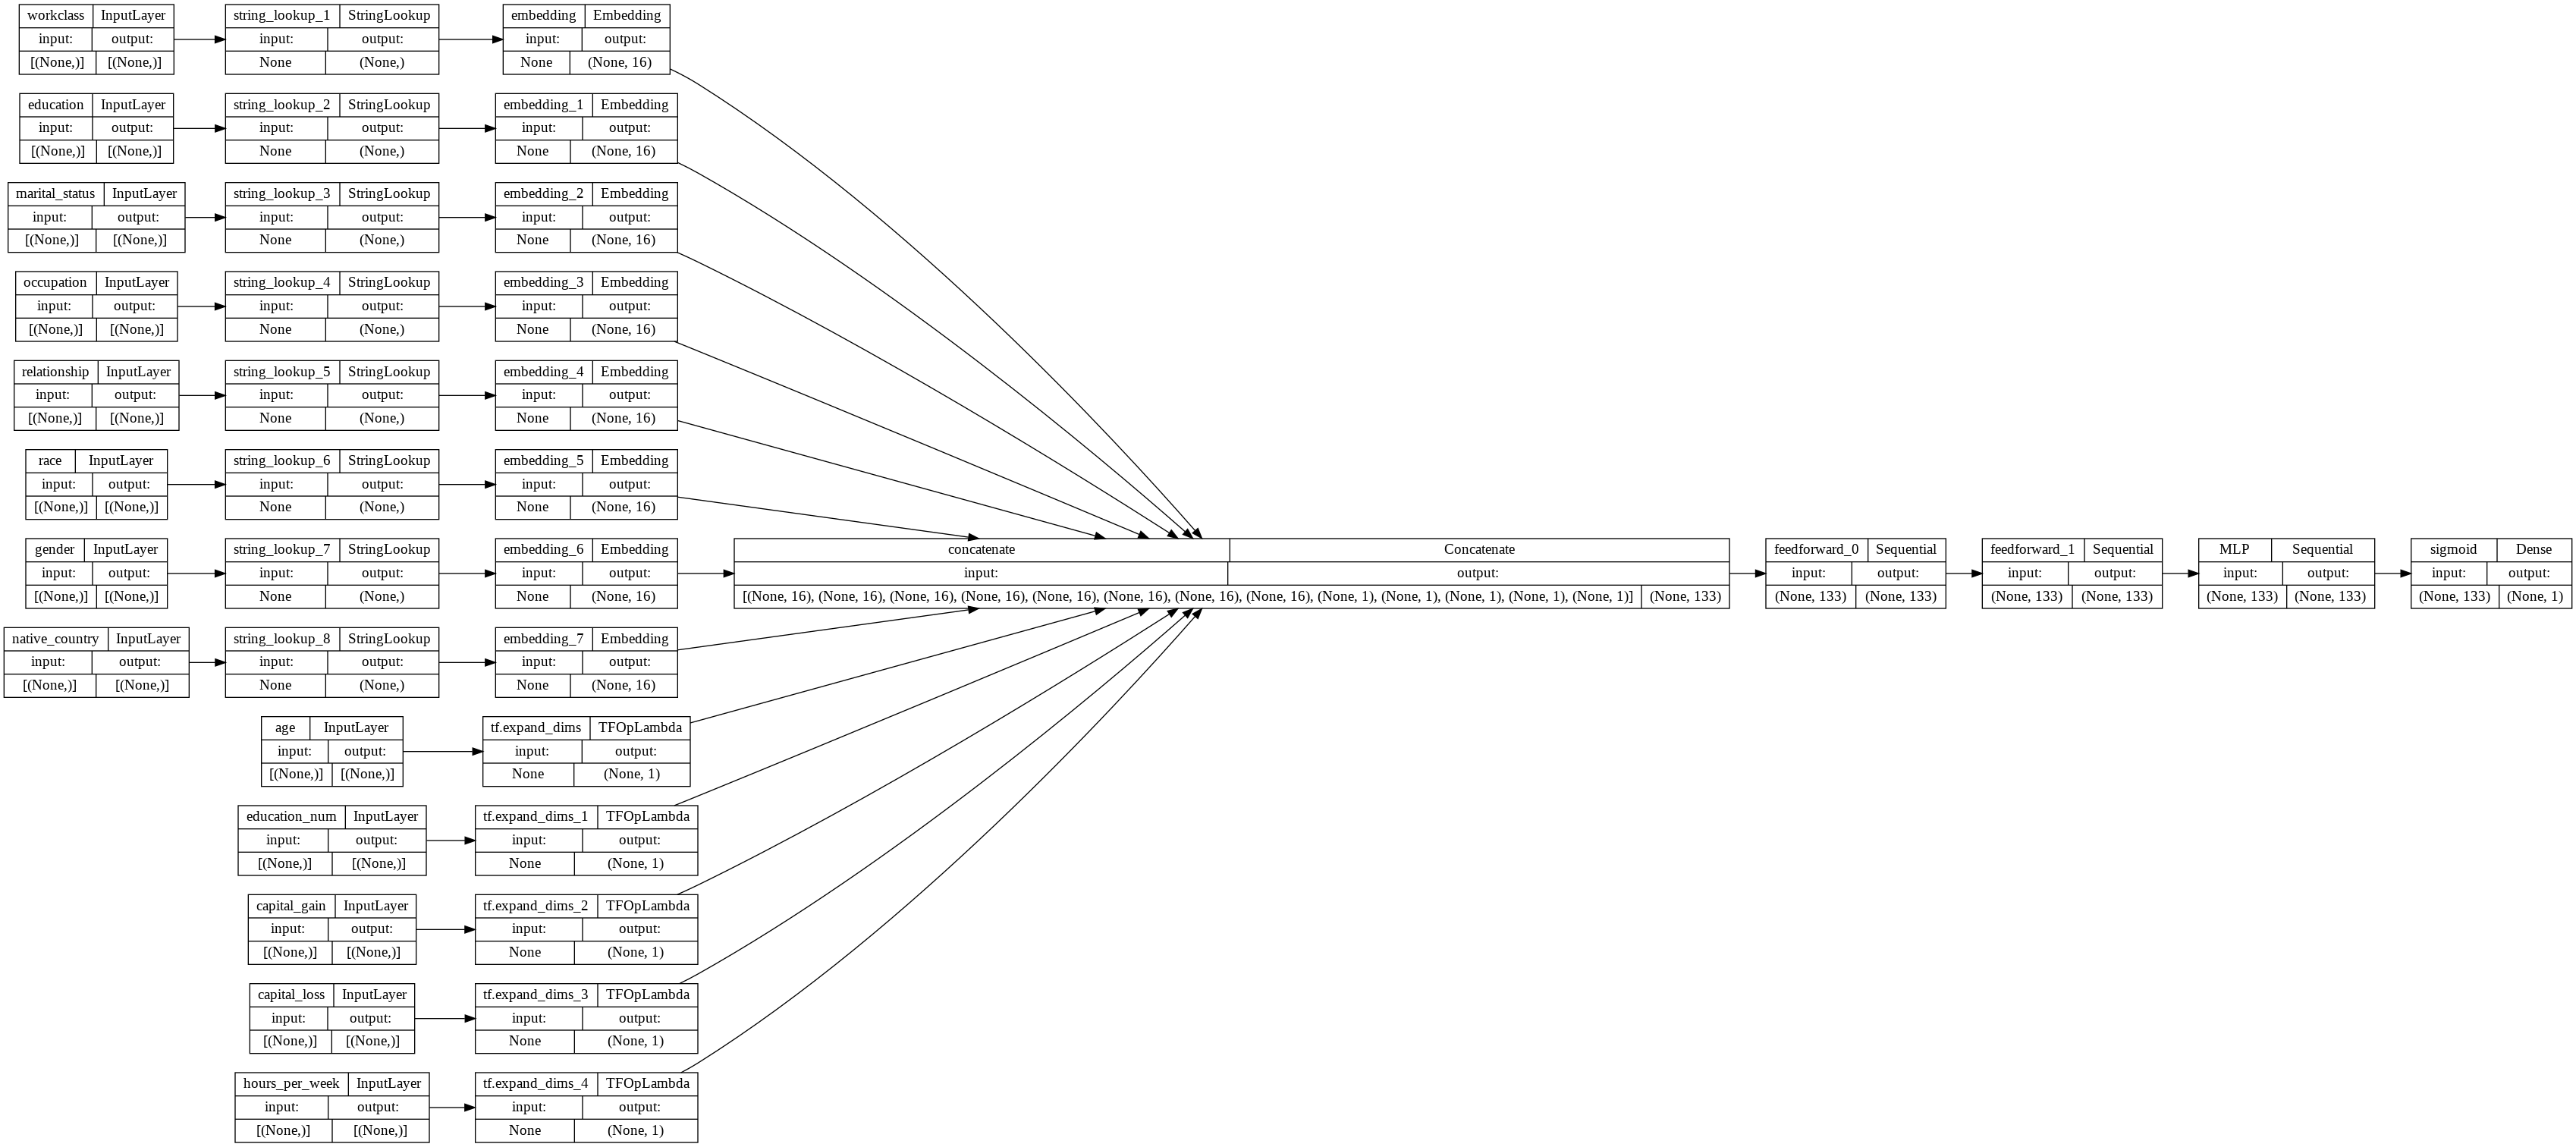

In [ ]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")

In [ ]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    123/Unknown - 5s 13ms/step - loss: 109274.3125 - accuracy: 0.7498

123/123 [==============================] - 6s 20ms/step - loss: 109274.3125 - accuracy: 0.7498 - val_loss: 92975.6953 - val_accuracy: 0.7826
Epoch 2/15
121/123 [============================>.] - ETA: 0s - loss: 92516.3828 - accuracy: 0.7688

123/123 [==============================] - 2s 13ms/step - loss: 92218.9766 - accuracy: 0.7693 - val_loss: 71875.5469 - val_accuracy: 0.7995
Epoch 3/15
120/123 [============================>.] - ETA: 0s - loss: 76801.0625 - accuracy: 0.7912

123/123 [==============================] - 2s 13ms/step - loss: 76728.6328 - accuracy: 0.7914 - val_loss: 67614.2734 - val_accuracy: 0.8183
Epoch 4/15
123/123 [==============================] - ETA: 0s - loss: 72495.3906 - accuracy: 0.8039

123/123 [==============================] - 2s 13ms/step - loss: 72495.3906 - accuracy: 0.8039 - val_loss: 66980.9531 - val_accuracy: 0.8165
Epoch 5/15
122/123 [============================>.] - ETA: 0s - loss: 70242.7188 - accuracy: 0.8061

123/123 [==============================] - 2s 13ms/step - loss: 70203.8750 - accuracy: 0.8061 - val_loss: 65882.5234 - val_accuracy: 0.8174
Epoch 6/15
122/123 [============================>.] - ETA: 0s - loss: 69150.8594 - accuracy: 0.8103

123/123 [==============================] - 2s 13ms/step - loss: 69105.2109 - accuracy: 0.8106 - val_loss: 66126.1562 - val_accuracy: 0.8221
Epoch 7/15
122/123 [============================>.] - ETA: 0s - loss: 68700.4141 - accuracy: 0.8113

123/123 [==============================] - 2s 13ms/step - loss: 68644.2031 - accuracy: 0.8116 - val_loss: 65627.4688 - val_accuracy: 0.8192
Epoch 8/15
122/123 [============================>.] - ETA: 0s - loss: 68057.7422 - accuracy: 0.8123

123/123 [==============================] - 2s 13ms/step - loss: 68008.7656 - accuracy: 0.8126 - val_loss: 66162.4609 - val_accuracy: 0.8111
Epoch 9/15
120/123 [============================>.] - ETA: 0s - loss: 67356.0000 - accuracy: 0.8145

123/123 [==============================] - 2s 13ms/step - loss: 67314.4453 - accuracy: 0.8149 - val_loss: 64744.5703 - val_accuracy: 0.8210
Epoch 10/15
122/123 [============================>.] - ETA: 0s - loss: 65864.9844 - accuracy: 0.8210

123/123 [==============================] - 2s 13ms/step - loss: 65796.5469 - accuracy: 0.8213 - val_loss: 67291.9844 - val_accuracy: 0.8238
Epoch 11/15
120/123 [============================>.] - ETA: 0s - loss: 64496.3438 - accuracy: 0.8282

123/123 [==============================] - 2s 13ms/step - loss: 64425.0469 - accuracy: 0.8285 - val_loss: 61986.7109 - val_accuracy: 0.8404
Epoch 12/15
123/123 [==============================] - ETA: 0s - loss: 63557.9023 - accuracy: 0.8309

123/123 [==============================] - 2s 17ms/step - loss: 63557.9023 - accuracy: 0.8309 - val_loss: 63568.8633 - val_accuracy: 0.8367
Epoch 13/15
123/123 [==============================] - ETA: 0s - loss: 63070.0312 - accuracy: 0.8346

123/123 [==============================] - 3s 24ms/step - loss: 63070.0312 - accuracy: 0.8346 - val_loss: 62019.3125 - val_accuracy: 0.8374
Epoch 14/15
121/123 [============================>.] - ETA: 0s - loss: 62709.2969 - accuracy: 0.8349

123/123 [==============================] - 3s 25ms/step - loss: 62694.1797 - accuracy: 0.8348 - val_loss: 61307.7852 - val_accuracy: 0.8372
Epoch 15/15
123/123 [==============================] - ETA: 0s - loss: 62128.0469 - accuracy: 0.8353

123/123 [==============================] - 2s 13ms/step - loss: 62128.0469 - accuracy: 0.8353 - val_loss: 63188.0781 - val_accuracy: 0.8370


Model training finished
Validation accuracy: 83.7%


Total model weights: 87479


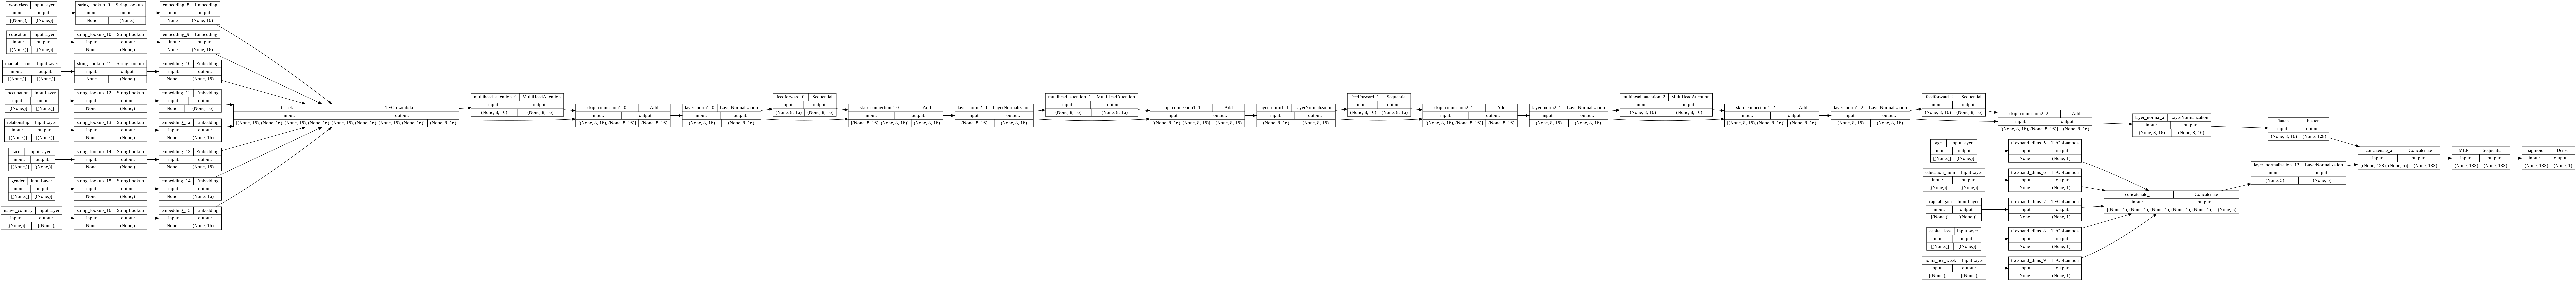

In [ ]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

In [ ]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    121/Unknown - 9s 22ms/step - loss: 80266.2500 - accuracy: 0.7965

123/123 [==============================] - 11s 33ms/step - loss: 80156.1797 - accuracy: 0.7965 - val_loss: 67158.2969 - val_accuracy: 0.8275
Epoch 2/15
122/123 [============================>.] - ETA: 0s - loss: 69290.3203 - accuracy: 0.8259

123/123 [==============================] - 3s 24ms/step - loss: 69302.5547 - accuracy: 0.8257 - val_loss: 63193.5664 - val_accuracy: 0.8431
Epoch 3/15
121/123 [============================>.] - ETA: 0s - loss: 66684.4375 - accuracy: 0.8310

123/123 [==============================] - 3s 24ms/step - loss: 66649.5156 - accuracy: 0.8308 - val_loss: 63534.8047 - val_accuracy: 0.8413
Epoch 4/15
121/123 [============================>.] - ETA: 0s - loss: 64948.7969 - accuracy: 0.8349

123/123 [==============================] - 3s 23ms/step - loss: 64956.2031 - accuracy: 0.8348 - val_loss: 62102.4219 - val_accuracy: 0.8436
Epoch 5/15
122/123 [============================>.] - ETA: 0s - loss: 63964.7773 - accuracy: 0.8376

123/123 [==============================] - 3s 23ms/step - loss: 63964.6953 - accuracy: 0.8374 - val_loss: 62783.8711 - val_accuracy: 0.8407
Epoch 6/15
121/123 [============================>.] - ETA: 0s - loss: 63341.0508 - accuracy: 0.8390

123/123 [==============================] - 3s 23ms/step - loss: 63328.0273 - accuracy: 0.8390 - val_loss: 62000.4609 - val_accuracy: 0.8430
Epoch 7/15
122/123 [============================>.] - ETA: 0s - loss: 62896.5547 - accuracy: 0.8415

123/123 [==============================] - 3s 28ms/step - loss: 62895.0742 - accuracy: 0.8415 - val_loss: 62247.3398 - val_accuracy: 0.8423
Epoch 8/15
122/123 [============================>.] - ETA: 0s - loss: 62405.3711 - accuracy: 0.8416

123/123 [==============================] - 3s 23ms/step - loss: 62418.7266 - accuracy: 0.8416 - val_loss: 62038.9453 - val_accuracy: 0.8424
Epoch 9/15
121/123 [============================>.] - ETA: 0s - loss: 62021.8359 - accuracy: 0.8427

123/123 [==============================] - 3s 24ms/step - loss: 62045.9102 - accuracy: 0.8424 - val_loss: 62102.6250 - val_accuracy: 0.8425
Epoch 10/15
122/123 [============================>.] - ETA: 0s - loss: 61754.1211 - accuracy: 0.8433

123/123 [==============================] - 3s 23ms/step - loss: 61773.8555 - accuracy: 0.8432 - val_loss: 62239.5234 - val_accuracy: 0.8410
Epoch 11/15
121/123 [============================>.] - ETA: 0s - loss: 61710.8711 - accuracy: 0.8435

123/123 [==============================] - 3s 23ms/step - loss: 61721.7578 - accuracy: 0.8435 - val_loss: 61574.9883 - val_accuracy: 0.8463
Epoch 12/15
121/123 [============================>.] - ETA: 0s - loss: 61584.6641 - accuracy: 0.8449

123/123 [==============================] - 3s 23ms/step - loss: 61614.9023 - accuracy: 0.8447 - val_loss: 62130.4414 - val_accuracy: 0.8415
Epoch 13/15
123/123 [==============================] - ETA: 0s - loss: 61324.2109 - accuracy: 0.8439

123/123 [==============================] - 3s 23ms/step - loss: 61324.2109 - accuracy: 0.8439 - val_loss: 61369.9336 - val_accuracy: 0.8446
Epoch 14/15
122/123 [============================>.] - ETA: 0s - loss: 61015.7656 - accuracy: 0.8449

123/123 [==============================] - 5s 37ms/step - loss: 61038.8164 - accuracy: 0.8447 - val_loss: 61845.7891 - val_accuracy: 0.8421
Epoch 15/15
123/123 [==============================] - ETA: 0s - loss: 61080.1367 - accuracy: 0.8446

123/123 [==============================] - 4s 36ms/step - loss: 61080.1367 - accuracy: 0.8446 - val_loss: 61592.7383 - val_accuracy: 0.8448


Model training finished
Validation accuracy: 84.48%


**Multiclass classification using Keras**

In [ ]:
# multi-class classification with Keras
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
# load dataset
dataframe = pandas.read_csv("iris.data", header=None)
dataset = dataframe.values
X = dataset[:,0:4].astype(float)
Y = dataset[:,4]
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(8, input_dim=4, activation='relu'))
	model.add(Dense(3, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 96.67% (5.37%)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import os

In [ ]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
dropout_rate = 0.2
#image_size = 32  # We'll resize input images to this size.
#patch_size = 4  # Size of the patches to be extracted from the input images.
#num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 128  # Number of hidden units.
num_blocks = 4  # Number of blocks.

In [ ]:
class gMLPLayer(layers.Layer):
    def __init__(self, embedding_dim, dropout_rate, *args, **kwargs):
        super(gMLPLayer, self).__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        #self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        #self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

In [ ]:
num_classes = 3
def build_classifier(blocks):
    inputs = layers.Input(shape=X)
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    #patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)
    
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
gmlp_blocks = keras.Sequential(
    [gMLPLayer(embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)


optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay,)
# Compile the model.
gmlp_classifier.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ])
# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    # Fit the model.
history = gmlp_classifier.fit(x=X, y=Y, batch_size=batch_size, epochs=num_epochs, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

TypeError: ignored